# Parser Functionality Demonstration

This notebook provides an overview over the functionality of der `README` file parser. The `README` file from UMET was chosen as an example. 

Based on the original `README` file format and the actually provided files from the different institutes, some adjustments are proposed to the file structure. These adjustments are meant to unify the content, as well as simplify the parsing of the `README` file.

For now the focus is set to the TGA experiments, to provide a base line for the discussion.

In [1]:
import os
import sys
import importlib
import copy
import pickle

import pandas as pd
import matplotlib.pyplot as plt


# Get current working directory.
cwd = os.getcwd()
print(cwd)

# # Absolute path to MaCFP matl repository,
# # e.g.: "D:\Git\MaCFP_matl_MyFork\matl-db"
# mafp_matl_root = os.path.join(cwd, "..")

# Build relative path to MaCFP matl repository.
mafp_matl_root = os.path.join("..")

# Add path to where Python looks for modules to import..
base_func_script = os.path.join(mafp_matl_root, "Utilities")
sys.path.insert(1, base_func_script)

# Import base_functions script.
import basic_functions as base_f
# Re-import base_functions script 
# (necessary for when the script changes 
# during development of the functionality).
importlib.reload(base_f)

D:\Git\MaCFP_matl_MyFork\matl-db\Utilities


<module 'basic_functions' from '..\\Utilities\\basic_functions.py'>

## General Information

Set up some general information for functionality utilised within this notebook.

In [2]:
# General info for this notebook.


# Get base structure of TGA experiment description.
tga_base = base_f.experiment_template["TGA_base"]


# Check results.
# tga_base

## Read the README File

In [3]:
# Path to the PMMA data.
pmma_path_elements = ["Non-charring", "PMMA"]
pmma_path = os.path.join(pmma_path_elements[0],
                         pmma_path_elements[1])

# Define the path to the desired file.
umet_path = os.path.join(mafp_matl_root,
                         pmma_path, 
                         "UMET")
umet_readme = os.path.join(umet_path, 'README.md')

# Read the file as list of strings (lines).
with open(umet_readme, encoding='utf8') as readme_file:
    readme_lines = [line.rstrip() for line in readme_file]
    

# Check results.
# readme_lines

## Get the Institute Name and Label

From the text, extract the title that contains the institute name and label.

In [4]:
institute_info = base_f.get_institute(readme_lines)
institute_info

['UMET', 'University of Lille - ENSCL - Unité Matériaux et Transformations']

## Get Experiment Information

Define an experiment to extract its information from the text.

In [5]:
# Read experiment description.
experiment_lines = base_f.read_experiment_lines(readme_lines)

# Check results.
experiment_lines

['### Experimental Conditions, TGA',
 '* Heating Rates: 1, 2, 5, 10, 20, 50, and 100 K/min',
 '* Temperature program',
 '  - Initial Temperature: 313.15 K',
 '  - Initial Isotherm: None',
 '  - Maximum Temperature: 1273.15 K',
 '  - Final Isotherm: None',
 '* Sample mass: 3.93 – 5.98 mg',
 '* Sample geometry: powdered',
 '* Calibration type: Temperature calibration was performed every 6 months using a set of 5 reference materials with melting temperatures between 156.6 - 660 C',
 '* Crucible',
 '  - Type: Al2O3',
 '  - Volume: 85 µL',
 '  - Diameter: None',
 '  - Mass: None',
 '  - Lid: None',
 '  - Note: None',
 '* Carrier Gas',
 '  - Type: Nitrogen',
 '  - Flow rate: 40 ml/min',
 '  - Note: Nitrogen (Vacuuming and filling according to the desired atmosphere)',
 '* Instrument',
 '  - Type: Netzsch TG 209 Libra',
 '  - Note: None',
 '###### Test Condition Summary',
 '| Test Label | Heating Rate (K/min) | Initial Sample Mass (mg) | Oxygen Concentration (vol %) | File Name |',
 '|:------

## Read Test Condition Table

From the experiment lines find and extract the markdown table that summarises the experimental conditions.

In [6]:
# Read table with experiment summary.
table_df = base_f.read_test_condition_table(experiment_lines)

# Check results.
table_df

Test Label  Heating Rate (K/min)  Initial Sample Mass (mg)  \
0  UMET_TGA_N2_1                   1.0                     4.336   
1  UMET_TGA_N2_2                   2.0                     4.845   
2  UMET_TGA_N2_3                   5.0                     4.093   
3  UMET_TGA_N2_4                  10.0                     5.339   
4  UMET_TGA_N2_5                  20.0                     3.929   
5  UMET_TGA_N2_6                  50.0                     5.980   
6  UMET_TGA_N2_7                 100.0                     5.364   

   Oxygen Concentration (vol %)           File Name  
0                           0.0    UMET_TGA_N2_1K_1  
1                           0.0    UMET_TGA_N2_2K_1  
2                           0.0    UMET_TGA_N2_5K_1  
3                           0.0   UMET_TGA_N2_10K_1  
4                           0.0   UMET_TGA_N2_20K_1  
5                           0.0   UMET_TGA_N2_50K_1  
6                           0.0  UMET_TGA_N2_100K_1

## Read Experiment Description

Now that the table information is extracted, it can be used to process the README and store the information of the individual experiments in a dictionary.

In [7]:
institute_name_info = institute_info

experiment_type = "TGA"
experiment_info = {experiment_type: dict()}
institute_label = institute_info[0]
repetition_info = {institute_label: dict()}

for test_label in table_df["Test Label"][:]:
    
    # Remove unnecessary spaces.
    test_label = test_label.replace(" ","")
    
    # Get line number of test.
    test_idx = table_df[table_df['Test Label'] == test_label].index[0]
    
    # Initialise experiment dictionary and fill in a copy of 
    # the experiment description template.
    test_info = copy.deepcopy(tga_base)
    
    
    # Set institute name and label.
    test_info['laboratory']['label'] = institute_name_info[0]
    test_info['laboratory']['name'] = institute_name_info[1]
    
    
    # Get file name
    data_file_name = table_df['File Name'][test_idx] + ".csv"
    # Build data file path.
    data_file_path = os.path.join(pmma_path, 
                                  institute_name_info[0],
                                  data_file_name)
    # Store relative data file path.
    test_info['path'] = data_file_path
    
    
    # Set experiment description items from README.
    base_f.readme_items(md_lines=experiment_lines, 
                        items=test_info)
#     readme_items(md_lines=experiment_lines, 
#                  items=test_info)
    
    # Set heating rate.
    new_val = table_df['Heating Rate (K/min)'][test_idx]
    new_unit = "K/min"
    test_info["heating_rate"] = {'value': new_val,
                                 'unit': new_unit}
    
    
    # Set initial sample mass.
    new_val = table_df['Initial Sample Mass (mg)'][test_idx]
    new_unit = "mg"
    test_info["sample_mass"] = {'value': new_val,
                                'unit': new_unit}
    
    
    repetition_info[institute_label][test_label] = test_info
#     print(data_file_path)
    
    
experiment_info[experiment_type] = repetition_info

In [8]:
# Check result.
experiment_info["TGA"]["UMET"]["UMET_TGA_N2_1"]["sample_mass"]

{'value': 4.336, 'unit': 'mg'}

# Plot Some Data

In [9]:
# Read experimental data.
tga_1k_file = experiment_info["TGA"]["UMET"]["UMET_TGA_N2_1"]["path"]
tga_1k_path = os.path.join(mafp_matl_root, 
                           tga_1k_file)

tga_1k_data = pd.read_csv(tga_1k_path,
                          skiprows=[1])

# Check result.
tga_1k_data.head()

Time  Temperature    Mass
0   0.0      313.115  4.3361
1   0.5      313.615  4.3361
2   1.0      314.115  4.3361
3   1.5      314.615  4.3361
4   2.0      315.115  4.3361

In [10]:
# Read experimental data.
tga_10k_file = experiment_info["TGA"]["UMET"]["UMET_TGA_N2_4"]["path"]
tga_10k_path = os.path.join(mafp_matl_root, 
                           tga_10k_file)

tga_10k_data = pd.read_csv(tga_10k_path,
                          skiprows=[1])

# Check result.
tga_10k_data.sample(5)

Time  Temperature      Mass
729  36.45      677.615  0.061140
170   8.50      398.115  5.316099
434  21.70      530.115  5.137593
494  24.70      560.115  5.080156
530  26.50      578.115  4.989912

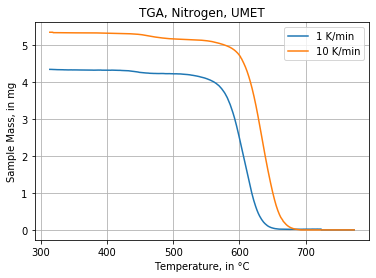

In [11]:
# Plot residual mass for UMET 1 K/min TGA test.
plt.plot(tga_1k_data.Temperature, 
         tga_1k_data.Mass, 
         label="1 K/min")

# Plot residual mass for UMET 10 K/min TGA test.
plt.plot(tga_10k_data.Temperature, 
         tga_10k_data.Mass, 
         label="10 K/min")


plt.title("TGA, Nitrogen, UMET")
plt.xlabel("Temperature, in °C")
plt.ylabel("Sample Mass, in mg")

plt.legend()
plt.grid()